# はじめに

本稿は，西村和雄著『ミクロ経済学』の「2.3 需要の決定」に沿って書いています。

技術的な話や経済学の話が入り混じることになるため読みづらいかと思いますが，
読んだり試したりしたものを組み合わせてメモとして残したいと考えています。


なお，使用している環境については下部に記載しています。


# 設定

## インテリセンスの有効化

Jupyter Notebook ではデフォルトでインテリセンスが有効になっておらず，不便なため有効化します。


In [1]:
# %matplotlib inline
%config IPCompleter.greedy=True

# 使用するパッケージなど

## SymPy

数式を扱うので当該パッケージを使用します。
init_printing は，数式を表示する際に使うようですが，よくわからないです(´・ω・｀)

In [2]:
import sympy
from sympy import plot, init_printing, var, solve, symbols, Eq

init_printing()

## その他

operator は演算子です。
functools はリストを操作する際に使います。
reduce は，総和とか総乗に使います。


In [3]:
from operator import mul, add
from functools import reduce

# 変数の定義

## 通常の変数

使用する変数を定義します。
一部しか使わないのですが，とりあえず a ～ z を対象にします。

なお，全微分する際に使いやすいように，定義したものをリストとして，sym_list へ格納しておきます。
※まぁ今回は不要ですが。


In [4]:
sym_list = list(var("a:z"))
sym_list

## 偏微分にて用いる記号

わざわざ書くほどのことではないのですが，偏微分の記号を定義しておきます。
※symbols として定義していない点に注意


In [5]:
rd = "∂"

## 財の消費量及び価格体系

今回対象となる財の種類は2つとします。

財の消費量は x とします。
財の数だけ添え字を振っていくこととなるため，リスト内包表記を使います。

価格は p とします。
添字は財の種類と対応させています。

In [6]:
N = 2

x = [symbols("x" + str(i+1)) for i in range(N)]
p = [symbols("p" + str(i+1)) for i in range(N)]
x, p

# 効用関数の定義

ここでは財の消費量をすべて掛けたものを効用関数としています。
逓減していないので，使えば使うほど効用が増すってことですかね(´・ω・｀)

ちなみに mul は，掛け算を意味しています。

reduce は引数として渡されたリストに対し，指定された演算子に従って計算します。
※回りくどい言い方をしましたが，要するに総乗します。


In [7]:
u_ = sympy.Eq(u, reduce(mul, x))
u_

# 予算制約式の定義

予算を I とします。

予算制約式は，
「財の消費量 × 価格 をすべての財について足したものが予算と一致する式」
ですね。

zip 関数とリスト内包表記を使って掛けます。

本当は予算以下であればいいのですが，効用を最大化させるという前提があるため，
「使える予算はすべて使う」
ということになり，上記の通り予算と一致することになります。


In [8]:
I = sympy.Symbol("I")

i_ = sympy.Eq(I, sum([x * p for (x, p) in zip(x, p)]))
i_

# ラグランジュ関数の定義

制約の中で効用を最大化させるため，ラグランジュの未定乗数法を使います。

ラグランジュ乗数を λ，ラグランジュ関数を L とします。

ラグランジュ関数についてですが，

1. 予算制約式の右辺をすべて左辺に移行させる。
1. ラグランジュ乗数を掛ける。
1. ラグランジュ乗数を掛けたものを効用関数へ加算する。

という手順で作ります。

In [9]:
rg = sympy.Symbol("λ")
L = sympy.Symbol("L")

con_ = i_.lhs - i_.rhs

L_ = sympy.Eq(L, u_.rhs + rg * con_)
L_

# ラグランジュ関数を偏微分する

## 偏微分する変数をリスト化する

財の消費量とラグランジュ乗数で偏微分するためリスト化します。
※以下，「偏微分リスト」と呼びます。

In [10]:
der_ = x
der_.append(rg)
der_

## 偏微分する

対象の関数について，偏微分リストの内容に基づいて偏微分します。


In [11]:
# 偏微分の対象となる関数
der_l_ = L_.lhs

# 偏微分
f_der_ = [sympy.Eq(sympy.symbols(rd + str(der_l_)) / sympy.symbols(rd + str(li)), L_.rhs.diff(li)) for li in der_ if L_.rhs.diff(li) != 0]
f_der_keys_ = [li.lhs for li in f_der_]

f_der_

# 一階条件を求める

偏微分したものについて，一階条件を求めます。
(各式の左辺を0をおきます。)


In [12]:
fod_ = [sympy.Eq(li.rhs, 0) for li in f_der_]
fod_

# 通常の需要関数を求める

2財の場合はラグランジュ乗数と合わせて、3次元n次方程式になります。

solve は，

- 第1引数 … 対象の式
- 第2引数 … 求める変数

を指定することにより解が返ってきます。
連立方程式の場合は，それらをリストとして渡します。

そのため，ここではラグランジュ関数の一階条件のリストと偏微分リストを渡します。


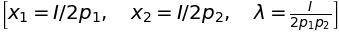

In [13]:
result = sympy.solve(fod_, der_)
result = [sympy.Eq(li, result[li]) for li in der_]

result

解のうち，左辺が財の消費量の式を「通常の需要関数」というようです。

# 間接効用関数を求める

通常の需要関数を効用関数へ代入します。

subs は，

- 第1引数 … 対象となる変数名
- 第2引数 … 代入する値

を指定することにより計算されます。
しかし，今回のように代入したい値が複数ある場合には辞書型の引数を渡します。

このため，

- 第1引数 … {対象となる変数名 : 代入する値}

といった形で指定します。

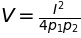

In [14]:
V = sympy.Symbol("V")

v_ = u_.subs({li.lhs : li.rhs for li in result})
v_ = sympy.Eq(V, v_.rhs)

v_


定義により，効用関数は財の消費量の関数です。
一方で，上記のように通常の需要関数を代入することにより，予算と価格体系の関数を導出することができました。

この関数を「間接効用関数」というようです。
間接効用関数は V とします。


# ラグランジュ乗数の意味について

通常の需要関数を求めたとき，解に左辺がラグランジュ乗数の式が含まれていました。
ラグランジュ乗数とはそもそもどのようなものなのか，という話ですが，書籍の P.32 に以下の通り記載されています。

> λは、“価格を一定として所得を1単位増加するときに、（需要の変化 dx1, …, dxn を通じて）得られる追加的効用”と等しい

つまり、間接効用関数 V を所得 I で偏微分したものと等しくなるようです。


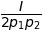

In [15]:
rg_test_ = sympy.diff(v_.rhs, I)
rg_test_

偏微分した結果を，ラグランジュ乗数の式と比較します。

In [16]:
re_ = [li.rhs for li in result if li.lhs == rg][0]

rg_test_ == re_

True

無事に一致しましたね(´・ω・｀)

# おわりに

題材とした『ミクロ経済学』は丁寧に解説が書かれています。
内容としては，恐らく手を動かしながら数式を解いていくことを前提としているように思えます。

実際に数式を解いていくうえでは非常にありがたかったりするのですが，
そもそもどのような意図でそのような操作を行っているのかが見えづらかったりします。

そこで，「数式を Python で解いてみる」という試みにより，
別の角度から理解することができたように思います。

今後も今回のように SymPy を使って『ミクロ経済学』を読んでいきたいと思います。
まだまだ不勉強ではありますが，「Python を使って『ミクロ経済学』を読む」みたいなシリーズでも書いてみたいですね。

※結構時間が掛かるので更新頻度は少ないかと思いますが(´・ω・｀)



## 補足


### 使用している環境について

今回使っていないものも含まれていますが，念のため載せておきます。

| IDEとかパッケージとか     | バージョン                           |
|:--------------------------|:-------------------------------------|
| Python                    | 3.6.0                                |
| Anaconda                  | 4.3.0 (64-bit)                       |
| PyCharm                   | 2018.1.2 (Community Edition)         |
| numpy                     | 1.16.0                               |
| sympy                     | 1.3                                  |
| matplotlib                | 3.0.2                                |

